## Reading the Smoke Estimates and AQI from Common Analysis - Part 1 

In [1]:
import seaborn as sns
import pandas as pd
import warnings
import glob 
import os 
warnings.filterwarnings("ignore")
##Reading Data for Smoke Estimate from Part 1 of Common Analysis 
smoke_df = pd.read_csv("../Data/Smoke_Estimate_Annual.csv")

##Reading Data for AQI from Part 1 of Common Analysis
aqi_df = pd.read_csv("../Data/aqi_yoy.csv")

## Merging Data between Smoke and AQI
merged_df = pd.merge(smoke_df, aqi_df, on='Year')

In [2]:
## Dropping useless variables from the merged dataframe
merged_df.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1,inplace=True)
merged_df.head()

,Year,Smoke_Estimate,Mean_Acres,Mean_Distance,AQI
0,1971,23.672270,1325.525988,811.390748,29.473214
1,1972,21.366843,815.347192,930.456507,25.860806
2,1973,18.726399,1265.033622,988.408613,26.414820
3,1974,11.230655,649.997485,890.307991,47.145204
4,1975,10.871741,729.997587,917.296712,42.049516


## Kansas Disease Mortality

In [3]:
## Reading data for mortality rate for different respiratory conditions
kansas_disease_mortality= pd.read_csv('../Data/kansas_disease_mortality.csv')
print(kansas_disease_mortality.shape)
## Filtering data for Sedgwick County based on location_id
kansas_disease_mortality_final_df = kansas_disease_mortality.loc[kansas_disease_mortality['location_id'] == 1540]
print(kansas_disease_mortality_final_df.shape)
kansas_disease_mortality_final_df.head(2)

(111300, 16)
(1050, 16)


,measure_id,measure_name,location_id,location_name,FIPS,cause_id,cause_name,sex_id,sex,age_id,age_name,year_id,metric,mx,lower,upper
9135,1,Deaths,1540,Sedgwick County,20173,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1980,Rate,72.777848,68.604459,77.222289
9136,1,Deaths,1540,Sedgwick County,20173,508,Chronic respiratory diseases,1,Male,27,Age-standardized,1981,Rate,74.563911,70.342567,78.855443


In [4]:
kansas_disease_mortality_final_df = kansas_disease_mortality_final_df.merge(merged_df, left_on= 'year_id', right_on= 'Year', how = 'inner')

# First Visualization

## Plotting Mortality Rates for Respiratory Conditions between Males and Females

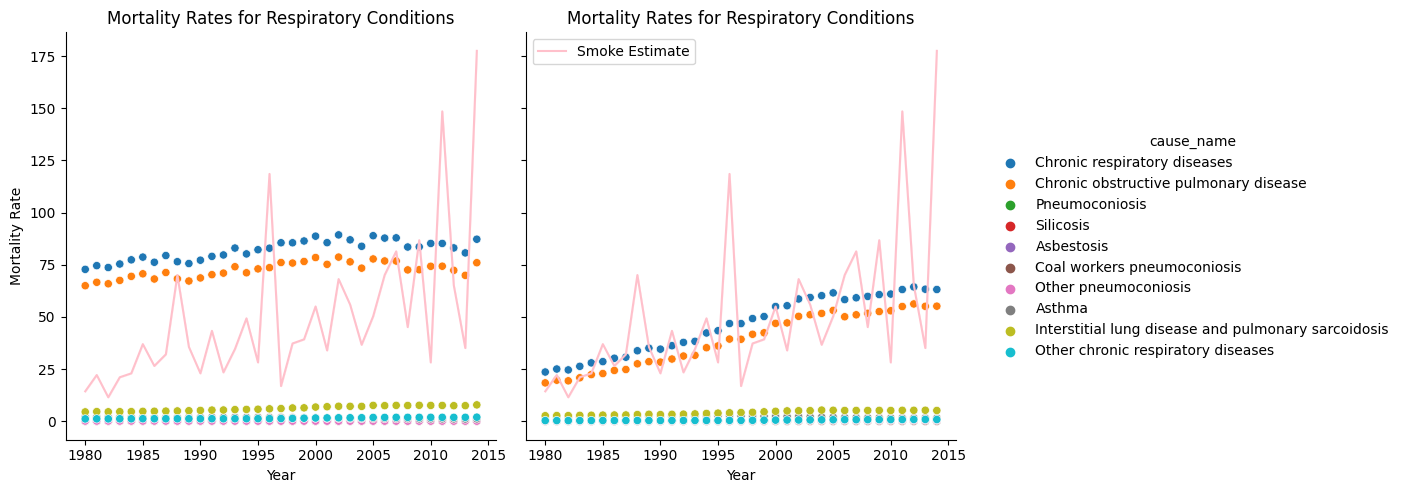

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

## Plotting the Data using Seaborn library
g = sns.relplot(
    x='year_id', 
    y='mx', 
    data=kansas_disease_mortality_final_df.loc[kansas_disease_mortality_final_df.sex!='Both'], 
    kind='scatter', 
    hue = 'cause_name',
    col='sex')

## Adding a Line plot for the Smoke Estimate calculated in Part 1
g.map(sns.lineplot, 'Year', 'Smoke_Estimate',data = kansas_disease_mortality_final_df,color='pink',label='Smoke Estimate', legend=True)
g.set_axis_labels("year_id", "mx")
g.set(xlabel ="Year", ylabel = "Mortality Rate", title ='Mortality Rates for Respiratory Conditions')

plt.legend(loc='right', labels=['Legend for Line Plot', 'Smoke Estimate'])
plt.legend(markerscale=0)
plt.show(g)

### The above plot shows the increasing mortality rates across different respiratory conditions between males and females. The plot has a lineplot representing the Smoke Estimate for Sedgwick County in the background in pink

## To further validate the trend seen in the visualization, I checked the percentage change in mortality rate for all respiratory diseases between males and females

In [6]:
## Reading data for percentage change in mortality rates between 1980 - 2014
change_in_disease= pd.read_csv('../Data/1980_2014_percentage_change_diseases.csv')
print(change_in_disease.shape)
## Filtering data for Sedgwick County based on location_id
change_in_disease_final_df = change_in_disease.loc[change_in_disease['location_id'] == 1540]
print(change_in_disease_final_df.shape)
change_in_disease_final_df.head(2)

(95820, 15)
(30, 15)


,measure_id,measure_name,location_id,location_name,FIPS,cause_id,cause_name,sex_id,sex,age_id,age_name,metric,pc_change_val,lower,upper
3078,1,Deaths,1540,Sedgwick County,20173.0,508,Chronic respiratory diseases,1,Male,27,Age-standardized,Rate,19.858884,10.894776,29.673070
3079,1,Deaths,1540,Sedgwick County,20173.0,508,Chronic respiratory diseases,2,Female,27,Age-standardized,Rate,167.735528,147.171871,192.848995


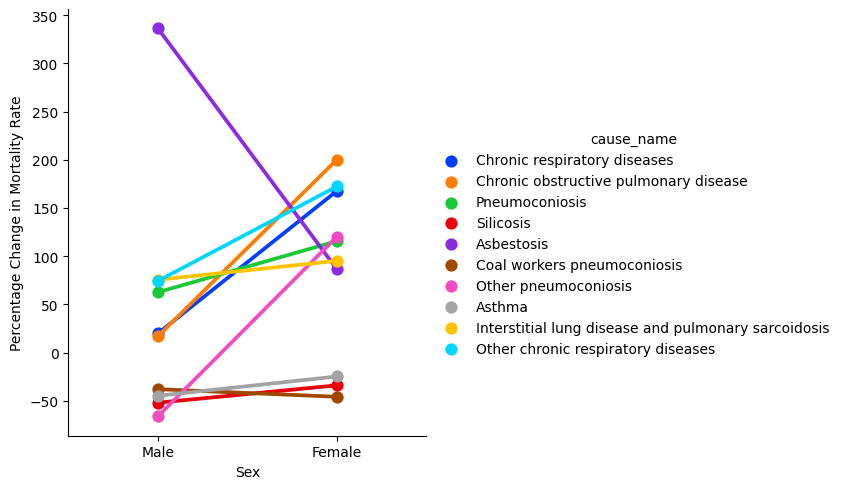

In [7]:
## Doing a comparative analysis for percentage change for each respiratory condition between Males and Females
g = sns.catplot(
    x='sex', 
    y='pc_change_val', 
    data=change_in_disease_final_df.loc[change_in_disease_final_df.sex!='Both'], 
    palette='bright',
    kind='point',
    hue='cause_name')
g.set(xlabel ="Sex", ylabel = "Percentage Change in Mortality Rate")


## Validating the Hypothesis seen in the above visualizations by finding the correlation between Increasing Mortality Rate in Females for Chronic obstructive pulmonary disease and Smoke Estimate over the last few years

In [23]:
## Filtering the data for the Mortality rate for Females for Chronic obstructive pulmonary disease 
kansas_disease_mortality_final_df.loc[(kansas_disease_mortality_final_df.cause_name == "Chronic obstructive pulmonary disease") & (kansas_disease_mortality_final_df.sex == 'Female')].shape
corr_mortality = kansas_disease_mortality_final_df.loc[(kansas_disease_mortality_final_df.cause_name == "Chronic obstructive pulmonary disease") & (kansas_disease_mortality_final_df.sex == 'Female')][['year_id','mx']]
corr_mortality.reset_index(drop=True, inplace=True)
## Merging the filtered data with the Smoke Estimate Dataframe for the years between 1980 - 2014
merged_df_corr = merged_df.loc[(merged_df.Year >=1980)  & (merged_df.Year <=2014)][['Year','Smoke_Estimate']]
merged_df_corr.shape

(35, 2)

## Calculating both the Pearson correlation coefficient and Spearman correlation coefficient. Pearson correlation coefficient has an assumption that the data is normally distributed and hence Spearman correlation coefficient was also calculated which has no assumptions

In [9]:
from scipy.stats import pearsonr, spearmanr

print('\n')
# Pearson correlation coefficient
pearson_corr, pearson_p_value = pearsonr(corr_mortality['mx'], merged_df_corr['Smoke_Estimate'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"P-Value: {pearson_p_value}")

print('\n')
# Spearman correlation coefficient
spearman_corr, spearman_p_value = spearmanr(corr_mortality['mx'], merged_df_corr['Smoke_Estimate'])
print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"P-Value: {spearman_p_value}")



Pearson Correlation Coefficient: 0.5477493747167843
P-Value: 0.0006595317716111251


Spearman Correlation Coefficient: 0.6630252100840336
P-Value: 1.4236497356140295e-05


## p-value is significant for both test even when there is no assumption on normality


# Second Visualization

## Checking for Mortality Rate for different ethnicities for Cardio Vascular Diseases

In [24]:
## Creating a function to create categories for different age groups

def creat_age_bins(df):
    df.loc[((df.age_name == '<1 year') | (df.age_name == '1 to 4') | (df.age_name == '5 to 9') | (df.age_name == '10 to 14') | (df.age_name == '15 to 19')),'Age_bin'] = 'Children'
    df.loc[((df.age_name == '20 to 24') | (df.age_name == '25 to 29') | (df.age_name == '30 to 34')),'Age_bin'] = 'Young Adults'
    df.loc[((df.age_name == '35 to 39') | (df.age_name == '40 to 44') | (df.age_name == '45 to 49') | (df.age_name == '50 to 54') | (df.age_name == '55 to 59')),'Age_bin'] = 'Adults'
    df.loc[((df.age_name == '60 to 64') | (df.age_name == '65 to 69') | (df.age_name == '70 to 74') | (df.age_name == '75 to 79') | (df.age_name == '80 to 84') | (df.age_name == '85 plus')),'Age_bin'] = 'Seniors'
    return df

In [11]:
## Reading data for the mortality rate for cardiovascular health over the years
folder_name = '../Data/cardio_both/'
file_type = 'csv'
seperator =','
cardio_both = pd.concat([pd.read_csv(f, sep=seperator) for f in glob.glob(folder_name + "/*."+file_type)],ignore_index=True)
print(cardio_both.shape)
## Filtering the data for Sedgwick County (Kansas)
cardio_both_final = cardio_both.loc[cardio_both['location_id'] == 1540]
print(cardio_both_final.shape)
cardio_both_final.head(2)

(8089200, 19)
(2520, 19)


,measure_id,measure_name,location_id,location_name,fips,race_id,race_name,sex_id,sex_name,age_group_id,age_name,cause_id,cause_name,year,metric_id,metric_name,val,upper,lower
115932,1,Deaths,1540,Sedgwick County (Kansas),20173.0,1,Total,3,Both,28,<1 year,491,Cardiovascular diseases,2000,3,Rate,0.000139,0.000188,0.000099
115933,1,Deaths,1540,Sedgwick County (Kansas),20173.0,2,Latino,3,Both,28,<1 year,491,Cardiovascular diseases,2000,3,Rate,0.000129,0.000206,0.000071


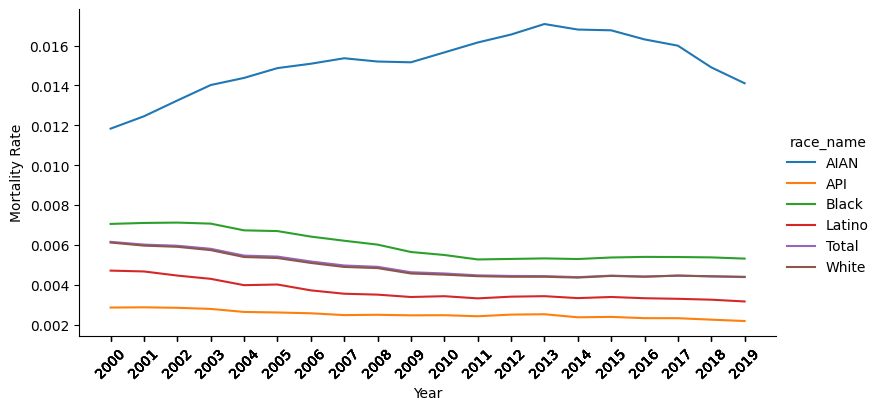

In [25]:
## Creating Categories based on Age Group
cardio_both_final = creat_age_bins(cardio_both_final)
cardio_both_final_plot = cardio_both_final.groupby(['year', 'Age_bin','race_name'])['val'].mean().reset_index()
cardio_both_final_plot = cardio_both_final_plot.loc[cardio_both_final_plot.Age_bin != 'nan']
## Aggregating Data using groupby for Mortality rates across different ethnicities over the years
final_plot = cardio_both_final_plot.groupby(['year','race_name'])['val'].mean().reset_index()
import seaborn as sns
#fig, ax = plt.subplots(figsize=(12, 6))

## Plotting Mortality Rate of Different Ethnicities for Cardiovascular Diseases
g =sns.relplot(
    x='year', 
    y='val', 
    kind='line',
    data=final_plot,aspect = 2, height = 4,
    hue = 'race_name')
plt.xticks(final_plot['year'],rotation=45)
g.set(xlabel ="Year", ylabel = "Mortality Rate")
plt.show(g)

## I noticed that mortality rates were higher for AIAN for both respiratory and cardiovascular health conditions. In order to further confirm this pattern, I checked the Life Expectancy at birth for different ethnicities. 

In [13]:
## Reading data for Life Expetancy
folder_name = '../Data/Life_Expectancy/'
file_type = 'csv'
seperator =','
life_Expectancy = pd.concat([pd.read_csv(f, sep=seperator) for f in glob.glob(folder_name + "/*."+file_type)],ignore_index=True)
print(life_Expectancy.shape)
## Filtering data for Sedgwick County (Kansas)
life_Expectancy_final = life_Expectancy.loc[life_Expectancy['location_id'] == 1540]
print(life_Expectancy_final.shape)
life_Expectancy_final.head(2)

(7318800, 17)
(2280, 17)


,measure_id,measure_name,location_id,location_name,fips,race_id,race_name,sex_id,sex_name,age_group_id,age_name,year,metric_id,metric_name,val,upper,lower
104940,26,Life expectancy,1540,Sedgwick County (Kansas),20173.0,1,Total,3,Both,28,<1 year,2000,1,Number,76.338913,76.589990,76.088079
104941,26,Life expectancy,1540,Sedgwick County (Kansas),20173.0,2,Latino,3,Both,28,<1 year,2000,1,Number,79.107087,80.303564,77.871678


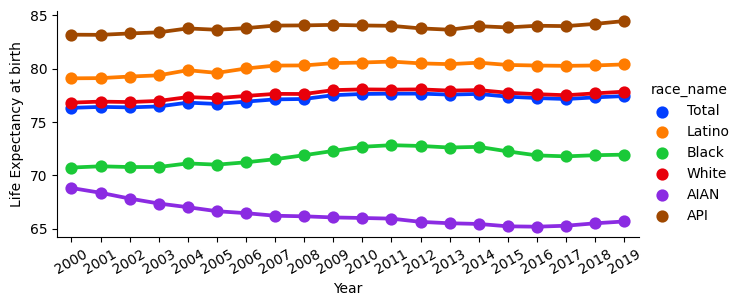

In [14]:
## Plotting Life Expectancy for Different Ethnicities
g = sns.catplot(
        x='year', 
        y='val', 
        data=life_Expectancy_final.loc[life_Expectancy_final.age_name == '<1 year'],
        palette='bright',
        height=3,aspect = 2.2,
        kind='point',
        hue='race_name')
plt.xticks(rotation = 30)
g.set(xlabel ="Year", ylabel = "Life Expectancy at birth")
plt.show()

## My hypothesis was reaffirmed as the Life Expectancy for AIAN has been on decline over the last few years

## Now checked if there was any statistical significance to the difference in average mortality rate for different races. Used ANOVA as there were more than two groups to check for difference between average mortality rate of different groups

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'val ~ year* race_name'
model = ols(formula, data=final_plot).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

## The interaction effect (race_name and year) is statistically significant (p < 0.05), indicating that there is evidence of an interaction effect


## Checking for Road Accidents and Transport Injuries with the Smoke Estimates over the years"

## Reading All Files for Road Accidents between 2000 - 2019

In [17]:
## Reading Data for Accidents and transport injuries
folder_name = '../Data/accident_both/'
file_type = 'csv'
seperator =','
accident_both = pd.concat([pd.read_csv(f, sep=seperator) for f in glob.glob(folder_name + "/*."+file_type)],ignore_index=True)
print(accident_both.shape)
## Filtering for Sedgwick County (Kansas)
accident_both = accident_both.loc[accident_both['location_id'] == 1540]
print(accident_both.shape)
accident_both.head(2)

(8089200, 19)
(2520, 19)


,measure_id,measure_name,location_id,location_name,fips,race_id,race_name,sex_id,sex_name,age_group_id,age_name,cause_id,cause_name,year,metric_id,metric_name,val,upper,lower
115932,1,Deaths,1540,Sedgwick County (Kansas),20173.0,1,Total,3,Both,28,<1 year,688,Transport injuries,2000,3,Rate,0.000050,0.000068,0.000037
115933,1,Deaths,1540,Sedgwick County (Kansas),20173.0,2,Latino,3,Both,28,<1 year,688,Transport injuries,2000,3,Rate,0.000066,0.000102,0.000039


## Filtering and Aggregating Mortality Rates for Road Accidents across different Age Categories. Then merging data  with Smoke Estimate dataframe

In [18]:
## Filtering aggregated data for all ethnicties 
accident_both_filtered = accident_both.loc[accident_both.race_name == 'Total']
print(accident_both_filtered.shape)
## Creating categories for different age groups
accident_both_filtered = creat_age_bins(accident_both_filtered)
## Aggregating Mortality rates for different Age Groups over the years
accident_both_filtered_plot = accident_both_filtered.groupby(['year', 'Age_bin'])['val'].mean().reset_index()
## Removing Nulls from the data
accident_both_filtered_plot = accident_both_filtered_plot.loc[accident_both_filtered_plot.Age_bin != 'nan']

(420, 19)


In [19]:
## Pivoting the data to create a dataframe which can be used for plotting
check = accident_both_filtered_plot.pivot_table(columns='Age_bin',index='year' ,values ='val',fill_value=0).reset_index()
## Merging the Above Aggregated Data with Smoke Estimate from Part 1 
accident_both_filtered_plot = check.merge(merged_df,left_on = 'year',right_on = 'Year', how = 'inner')
check.columns

Index(['year', 'Adults', 'Children', 'Seniors', 'Young Adults'], dtype='object', name='Age_bin')

## Plotting the Average Mortality Rate for different Age categories along with the Smoke Estimate for those years in the background

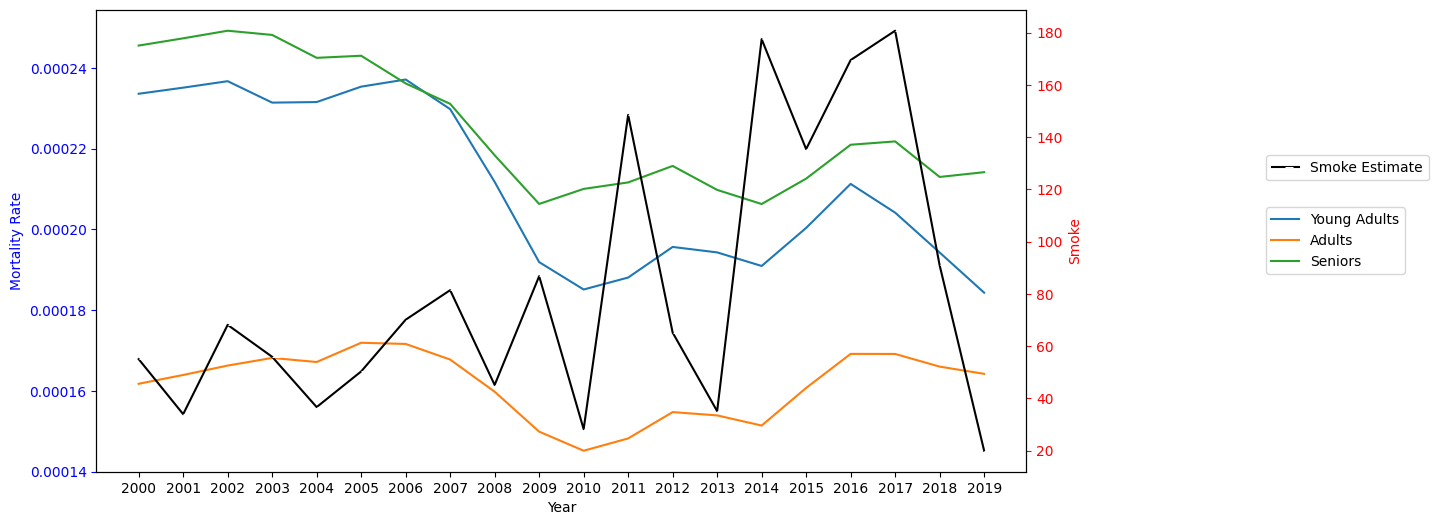

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
g= sns.lineplot(x='Year', y='Young Adults', data=accident_both_filtered_plot, ax=ax, label='Young Adults')
sns.lineplot(x='Year', y='Adults', data=accident_both_filtered_plot, ax=ax, label='Adults')
sns.lineplot(x='Year', y='Seniors', data=accident_both_filtered_plot, ax=ax, label='Seniors')
ax.set_xlabel('Year')
ax.set_ylabel('Mortality Rate', color='blue')
ax.tick_params('y', colors='blue')
ax2 = ax.twinx()
sns.lineplot(x='Year', y='Smoke_Estimate', data=accident_both_filtered_plot, ax=ax2, color='black', label = 'Smoke Estimate', marker = True)
plt.legend(loc='upper right',bbox_to_anchor=(1.44, 0.7), ncol=1)

ax2.set_ylabel('Smoke', color='red')
ax2.tick_params('y', colors='red')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.set_xticks(accident_both_filtered_plot['Year'])
ax.set_xticklabels(accident_both_filtered_plot['Year'])
plt.xticks(rotation=45)
# Show the plot
plt.show(g)

## Checking for Statistical Significance in terms of Correlation  between increase in Mortality rates due to road accidents and Smoke Estimate especially for the Senior Age Category

In [21]:
from scipy.stats import pearsonr, spearmanr

print('\n')
# Pearson correlation coefficient
pearson_corr, pearson_p_value = pearsonr(accident_both_filtered_plot['Seniors'], accident_both_filtered_plot['Smoke_Estimate'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"P-Value: {pearson_p_value}")

print('\n')
# Spearman correlation coefficient
spearman_corr, spearman_p_value = spearmanr(accident_both_filtered_plot['Seniors'], accident_both_filtered_plot['Smoke_Estimate'])
print(f"Spearman Correlation Coefficient: {spearman_corr}")
print(f"P-Value: {spearman_p_value}")



Pearson Correlation Coefficient: -0.3632132603672961
P-Value: 0.11547330752707058


Spearman Correlation Coefficient: -0.2270676691729323
P-Value: 0.3356744310134179


## Negative Correlation between Road Accidents for Seniors and Smoke Estimate
## However, an important thing to notice that the p-value is not less than 0.05 and  hence this correlation is not statistically significant
